<a href="https://colab.research.google.com/github/dekings44/students_companion_bot/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is the codebase of my masters degree project.**

**Project Title:** *How Effective is AI in Delivering Personalized Learning Paths for Students? A Hands-on Approach with Generative AI.*

**The Problem I am trying to solve:** *This project aims to explore the effectiveness of AI in creating personalized learning paths that caters to individual students’ needs, enhancing learning experience and outcomes.*

**Expected End Product**



> A comprehensive report detailing the AI tutor's effectiveness, measured through metrics like student engagement, understanding, performance, and feedback


> AI Bot Web Embedded Application working prototype capable of delivering personalized learning paths for students based on their individual learning styles, paces, and preferences.


> Working code of the AI Bot


**Name of the AI bot**: **Manda**, *the student companion*


Installation of all the libraries, models and modules that will be needed for this project.

In [1]:
!pip install -U transformers --quiet
!pip install -U accelerate --quiet
!pip install -U bertviz --quiet
!pip install -U umap-learn --quiet
!pip install torch torchvision torchaudio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.7 MB/s eta 0:00:00


In [2]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


import torch
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import AutoTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Masters Project/dataset.csv')

In [4]:
data.head()

Sentence      Type
0  Ali, who was two at the time, loved the story ...  Auditory
1  Look at my dad, spiffed up in jodhpurs, ready ...  Auditory
2  Believe me it's far more difficult to know wha...  Auditory
3  The Surrealists loved bad movies, seeing them ...  Auditory
4  He idolised prize-fighters, regarded racketeer...  Auditory

In [5]:
data['Type'].value_counts()

Visual         5827
Kinesthetic    4819
Auditory       4804
Name: Type, dtype: int64

In [6]:
num_rows, num_columns = data.shape
f'This dataset has {num_rows} rows and {num_columns} columns'

'This dataset has 15450 rows and 2 columns'

In [7]:
classes = data['Type'].unique()
classes

array(['Auditory', 'Visual', 'Kinesthetic'], dtype=object)

In [8]:
# This Function is to clean the dataset and remove the noise
def cleanData(data):
  data = re.sub(r'@[A-Za-z0-9_]+', '', data) # this will remove the @ mentions
  data = re.sub(r'#', '', data) # this will remove the # symbols
  data = re.sub(r'https?:\/\/\s+', '', data) # This will remove the hyperlink
  data = re.sub(r'\n+', '', data) # This will removes all mention of \n
  data = re.sub(r'_', '', data) # This will remove _
  data = re.sub(r'[0-9]', '', data) # This will remove numbers
  return data

In [9]:
data['cleaned_conversation'] = data['Sentence'].apply(cleanData)

**Exploratory Data Analysis**

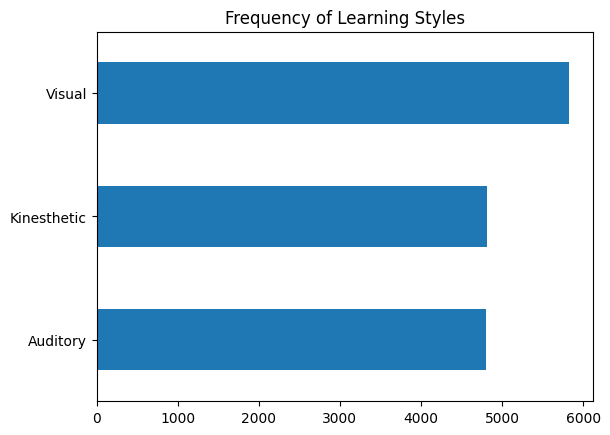

In [10]:
learning_styles = data['Type'].value_counts(ascending=True)
learning_styles.plot.barh()
plt.title('Frequency of Learning Styles')
plt.show()

<Axes: title={'center': 'Words Per Conversation'}, xlabel='Type'>

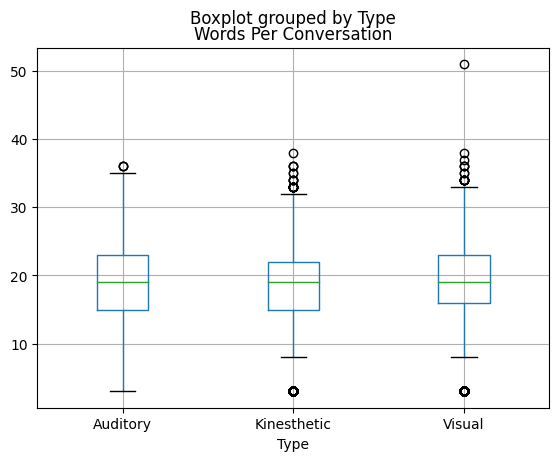

In [11]:
data['Words Per Conversation'] = data['cleaned_conversation'].str.split().apply(len)
data.boxplot("Words Per Conversation", by='Type')

In [12]:
# Assuming df is your DataFrame and 'Type' is the column with labels
labels = data['Type']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
numerical_labels = label_encoder.fit_transform(labels)

# Add the numerical labels to the DataFrame as a new column, let's call it 'Label'
data['Label'] = numerical_labels

In [13]:
classes = data['Label'].unique()
classes

array([0, 2, 1])

In [14]:
data.head()

Sentence      Type  \
0  Ali, who was two at the time, loved the story ...  Auditory   
1  Look at my dad, spiffed up in jodhpurs, ready ...  Auditory   
2  Believe me it's far more difficult to know wha...  Auditory   
3  The Surrealists loved bad movies, seeing them ...  Auditory   
4  He idolised prize-fighters, regarded racketeer...  Auditory   

                                cleaned_conversation  Words Per Conversation  \
0  Ali, who was two at the time, loved the story ...                      27   
1  Look at my dad, spiffed up in jodhpurs, ready ...                      16   
2  Believe me it's far more difficult to know wha...                      21   
3  The Surrealists loved bad movies, seeing them ...                      16   
4  He idolised prize-fighters, regarded racketeer...                      19   

   Label  
0      0  
1      0  
2      0  
3      0  
4      0

In [15]:
data.shape

(15450, 5)

In [18]:
data.tail(20)

Sentence         Type  \
15430  People in Cornwall will be parading about in h...  Kinesthetic   
15431  Our guess is that it wasn't until he saw her n...  Kinesthetic   
15432  Apparently the US Army spent twenty years tryi...  Kinesthetic   
15433  It was indeed the coldest day that Challenger ...  Kinesthetic   
15434  That is where the problems start, with Tony Bl...  Kinesthetic   
15435  A good deal of time is spent trying to catch s...  Kinesthetic   
15436  There is nothing better than watching us tryin...  Kinesthetic   
15437  In auctioning off monetary gold the managers o...  Kinesthetic   
15438  Many are trying to regulate this and are using...  Kinesthetic   
15439  Referees and their assistants have a very diff...  Kinesthetic   
15440  Unfortunately, the police department is trying...  Kinesthetic   
15441  The problems have affected callers trying to c...  Kinesthetic   
15442  It is surprising that no one is even talking o...  Kinesthetic   
15443  Irrigation before planting may work better tha...  Kinesthetic   
15444  An army of dirty children ran passed me, tryin...  Kinesthetic   
15445  Her appearance as the conwoman trying to fleec...  Kinesthetic   
15446  However mostly in these classes I am trying to...  Kinesthetic   
15447  No, I cannot lay down with a hanger hooked on ...  Kinesthetic   
15448  In the meantime, I'm trying to keep the organi...  Kinesthetic   
15449  The deciding run, in the fourth inning, came a...  Kinesthetic   

                                    cleaned_conversation  \
15430  People in Cornwall will be parading about in h...   
15431  Our guess is that it wasn't until he saw her n...   
15432  Apparently the US Army spent twenty years tryi...   
15433  It was indeed the coldest day that Challenger ...   
15434  That is where the problems start, with Tony Bl...   
15435  A good deal of time is spent trying to catch s...   
15436  There is nothing better than watching us tryin...   
15437  In auctioning off monetary gold the managers o...   
15438  Many are trying to regulate this and are using...   
15439  Referees and their assistants have a very diff...   
15440  Unfortunately, the police department is trying...   
15441  The problems have affected callers trying to c...   
15442  It is surprising that no one is even talking o...   
15443  Irrigation before planting may work better tha...   
15444  An army of dirty children ran passed me, tryin...   
15445  Her appearance as the conwoman trying to fleec...   
15446  However mostly in these classes I am trying to...   
15447  No, I cannot lay down with a hanger hooked on ...   
15448  In the meantime, I'm trying to keep the organi...   
15449  The deciding run, in the fourth inning, came a...   

       Words Per Conversation  Label  
15430                      20      1  
15431                      23      1  
15432                      25      1  
15433                      26      1  
15434                      20      1  
15435                      22      1  
15436                      19      1  
15437                      22      1  
15438                      14      1  
15439                      17      1  
15440                      11      1  
15441                      16      1  
15442                      17      1  
15443                      14      1  
15444                      14      1  
15445                      20      1  
15446                      20      1  
15447                      25      1  
15448                      13      1  
15449                      24      1

In [16]:
sentences = data['cleaned_conversation'].tolist()
learn_style = data['Label'].tolist()

In [70]:
len(sentences)

15450

In [71]:
type(sentences)

list

In [72]:
len(learn_style)

15450

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenized_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

#tokenized_inputs_array =  np.array(tokenized_inputs) #tokenized_inputs.numpy()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def tokenize(batch):
  temp =tokenizer(sentences, padding=True, truncation=True)
  return temp

print(tokenize(sentences[:5]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
print(len(tokenized_inputs), len(learn_style))

3 15450


In [27]:
tokenized_inputs

{'input_ids': tensor([[  101,  4862,  1010,  ...,     0,     0,     0],
        [  101,  2298,  2012,  ...,     0,     0,     0],
        [  101,  2903,  2033,  ...,     0,     0,     0],
        ...,
        [  101,  2053,  1010,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  1996, 10561,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [31]:
tokenized_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [32]:
tokenized_inputs.values()

dict_values([tensor([[  101,  4862,  1010,  ...,     0,     0,     0],
        [  101,  2298,  2012,  ...,     0,     0,     0],
        [  101,  2903,  2033,  ...,     0,     0,     0],
        ...,
        [  101,  2053,  1010,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  1996, 10561,  ...,     0,     0,     0]]), tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])])

In [33]:
print(len(tokenized_inputs['token_type_ids']), len(learn_style))

15450 15450


In [30]:
print(tokenized_inputs)

{'input_ids': tensor([[  101,  4862,  1010,  ...,     0,     0,     0],
        [  101,  2298,  2012,  ...,     0,     0,     0],
        [  101,  2903,  2033,  ...,     0,     0,     0],
        ...,
        [  101,  2053,  1010,  ...,     0,     0,     0],
        [  101,  1999,  1996,  ...,     0,     0,     0],
        [  101,  1996, 10561,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


**Split Data into Train Validate and Test**

In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    tokenized_inputs_array, learn_style, test_size=0.2, random_state=42
)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    train_inputs, train_labels, test_size=0.1, random_state=42
)


ValueError: ignored